## Variational AutoEncoder

### Original code from https://keras.io/examples/variational_autoencoder_deconv/

The VAE has a modular design. 
The encoder, decoder and VAE are 3 models that share weights. 

After training the VAE model, the encoder can be used to generate latent vectors.

The decoder can be used to generate images by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.


### Set environment: conda_keras

In [0]:
!pip install tensorflow-gpu

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model, model_from_json
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
from PIL import Image


Using TensorFlow backend.


### Re-parameterization trick

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon

# epsilon is a random number = noise

# encoder samples a random point z from latent normal distribution
# returns an fake image from: z_mean + K.exp(0.5 * z_log_var) * epsilon

# latent space is forced to be continously meaningful: points close in latent space will give similar images

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Build model

### Set dimensions

In [0]:
dim_orig_flat = 256 * 256 * 3 # = 196,608
dim_layer_1 = 256 # for first layer
dim_layer_2 = 128 # for second layer
dim_latent = 64 # for latent space, ultimate compression

### Encoder

In [0]:
input_img = Input(shape=(256, 256, 3)) 
x = Flatten()(input_img)


# Encoder
x = BatchNormalization()(x)
x = Dense(dim_layer_1, activation = 'relu')(x)
x = Dense(dim_layer_2, activation = 'relu')(x)

# use reparameterization trick to push the sampling out as input
x = BatchNormalization()(x)
z_mean = Dense(dim_latent, activation = 'relu')(x)
z_log_var = Dense(dim_latent, activation = 'relu')(x)

# this is the random point sampled from latent space
# Lambda wraps code into layer, required by Keras
z = Lambda(sampling, output_shape = (dim_latent, ))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z])
# encoder.summary()


W0719 10:32:16.383387 140190695913216 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 10:32:16.426460 140190695913216 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 10:32:16.610388 140190695913216 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 196608)       0                                            
__________________________________________________________________________________________________
encoder1 (Dense)                (None, 256)          50331904    encoder_input[0][0]              
__________________________________________________________________________________________________
encoder2 (Dense)                (None, 128)          32896       encoder1[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 64)           8256        encoder2[0][0]                   
__________________________________________________________________________________________________
z_log_var 

### Decoder

In [0]:
latent_inputs = Input(shape = (dim_latent, ), name = 'z_sampling')
x = Dense(dim_layer_2, activation = 'relu')(latent_inputs)
x = Dense(dim_layer_1, activation = 'relu')(x)
outputs = Dense(original_dim, activation = 'sigmoid')(x)

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 64)                0         
_________________________________________________________________
decoder1 (Dense)             (None, 128)               8320      
_________________________________________________________________
decoder2 (Dense)             (None, 256)               33024     
_________________________________________________________________
reconstructed_image (Dense)  (None, 196608)            50528256  
Total params: 50,569,600
Trainable params: 50,569,600
Non-trainable params: 0
_________________________________________________________________


### Combine, add loss functions and compile model

In [0]:
# combine model
outputs = decoder(encoder(inputs)[2])  
vae = Model(inputs, outputs)

# plot and save architecture
vae.summary()
plot_model(vae, to_file = '/content/drive/My Drive/Model_data/Layers_VAE_v1.png', show_shapes = True)

# Loss functions: 
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 196608)            0         
_________________________________________________________________
encoder (Model)              [(None, 64), (None, 64),  50381312  
_________________________________________________________________
decoder (Model)              (None, 196608)            50569600  
Total params: 100,950,912
Trainable params: 100,950,912
Non-trainable params: 0
_________________________________________________________________


W0719 10:32:20.893254 140190695913216 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0719 10:32:20.900428 140190695913216 deprecation.py:323] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0719 10:32:20.950280 140190695913216 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Image Augmentation

In [0]:
image_data_dir = '/content/drive/My Drive/PhenoCAT/labeled_images'
image_size = 256 # All images will be resized to 
batch_size = 5

In [0]:
# Rescale and augment
datagen = image.ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 180,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

# results in tuples of (x, y) where x is a numpy array containing a batch of images 
# with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.
train_generator = datagen.flow_from_directory(image_data_dir,                      
                                                target_size = (image_size, image_size), # default: 256
                                                color_mode='rgb', 
                                                batch_size = batch_size,
                                                class_mode = 'input', # when images identical to input images (autoencoders)
                                                # save_to_dir = 'path' saves augmented images 
                                                # save_prefix='augm_', 
                                                # save_format='png', 
                                                subset='training') # 'validation'
                   

validation_generator = datagen.flow_from_directory(image_data_dir,
                                                target_size = (image_size, image_size), # default: 256
                                                color_mode='rgb', 
                                                batch_size = batch_size, 
                                                class_mode = 'input',
                                                # save_to_dir = 'path' saves augmented images 
                                                # save_prefix='augm_', 
                                                # save_format='png', 
                                                subset='validation') # 'validation'



### Train VAE

In [0]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs = 50

print(steps_per_epoch,validation_steps)

In [0]:
history = vae.fit_generator(train_generator,
                                    steps_per_epoch = steps_per_epoch,
                                    epochs = epochs,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps)

# save model and architecture to single file
vae.save("/content/drive/My Drive/Model_data/VAE_v1.h5")
encoder.save("/content/drive/My Drive/Model_data/VAE_v1_encoder.h5")

print("Saved model and weights")


In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']


x_epochs = range(1,epochs+1)

plt.figure()
plt.plot(x_epochs, np.log(loss), 'b', label = 'Training loss')
plt.plot(x_epochs, np.log(val_loss), 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.show()

plt.savefig('/content/drive/My Drive/Model_data/Loss_curve_VAE_v1.pdf')

### Predict a single image and plot real image, latent space, reconstructed image

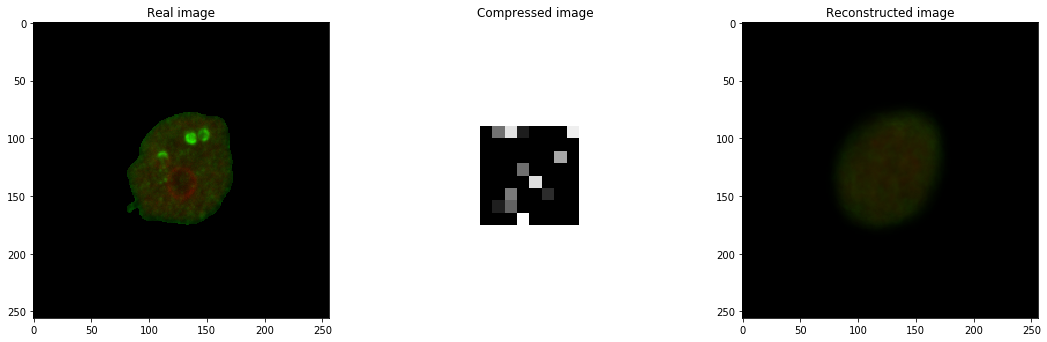

In [0]:
# pick a number
# 217, 29 good
im_number = 120


# get real image:
real_image_vec = (np.asarray(x_test[im_number]) * 255).astype(np.uint8)
real_image_arr = real_image_vec.reshape(image_shape)
real_image = Image.fromarray(real_image_arr)
 
# get latent space compressed image
z_mean, _, _ = encoder.predict(x_test[im_number])
latent_image = z_mean.reshape(8,8) 

# get reconstructed image:
# fake_image_vec = (np.asarray(image_decoded) * 255).astype(np.uint8)
# fake_image_arr = fake_image_vec.reshape(image_shape)
# fake_image = Image.fromarray(fake_image_arr)
fake_image_vec = vae.predict(x_test[im_number])
fake_image = fake_image_vec.reshape(image_shape)



# plot
plt.rcParams['figure.figsize'] = (18,12)
fig, [ax1, ax2, ax3] = plt.subplots(1,3)

ax1.imshow(real_image)
ax1.set_title('Real image')

ax2.imshow(latent_image, cmap = 'Greys_r')
ax2.set_title('Compressed image')
ax2.set_xlim([-8, 16])
ax2.set_ylim([-8, 16])
ax2.axis('off')
    
ax3.imshow(fake_image)
ax3.set_title('Reconstructed image')
None

### Cluster latent space z_mean

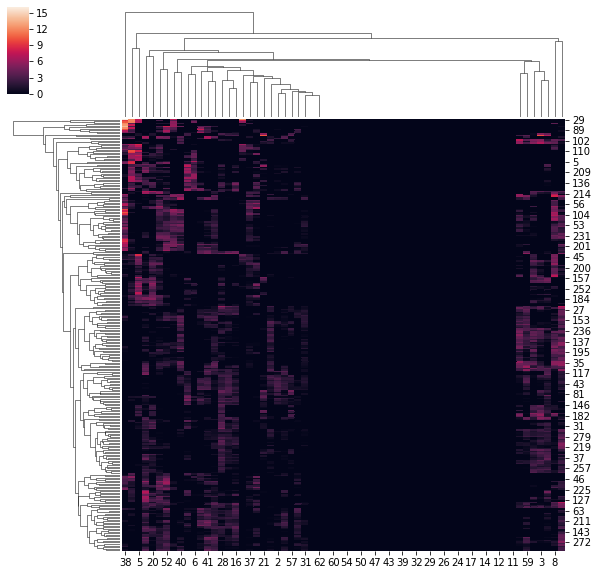

In [0]:
import seaborn as sns
z_mean_test, _, _ = encoder.predict(x_test)

sns.clustermap(z_mean_test, metric = 'euclidean')
None

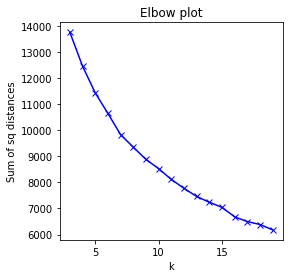

In [0]:
from sklearn.cluster import AgglomerativeClustering, KMeans

# loop over diff cluster numbers to find optimal k
Sum_of_squared_distances = []
for i in range(3,20):
    result_kmeans = KMeans(n_clusters = i).fit(z_mean_test)
    Sum_of_squared_distances.append(result_kmeans.inertia_)
        
# Plot the elbow
plt.rcParams['figure.figsize'] = (4, 4)
plt.plot(range(3,20), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of sq distances')
plt.title('Elbow plot')
None

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA()
pca_obj = pca.fit(z_mean_test) 


In [0]:
len(np.cumsum(pca_obj.explained_variance_ratio_))

64

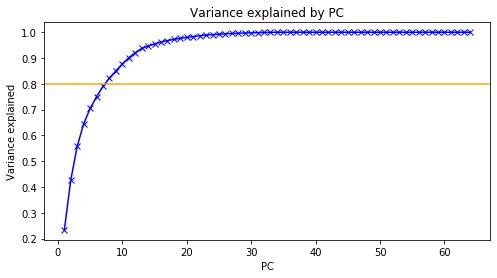

In [0]:
x_lab = list(range(1,z_mean_test.shape[1]+1))

plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(x_lab, np.cumsum(pca_obj.explained_variance_ratio_),'bx-')
plt.axhline(y = 0.8,color = 'orange')
plt.xlabel('PC')
plt.ylabel('Variance explained')
plt.title('Variance explained by PC')
None

In [0]:
# Cluster 7 PC
my_pca = PCA(n_components = 7)
my_pca_obj = my_pca.fit(z_mean_test)
data_pca = my_pca.fit_transform(z_mean_test)

# convert into df
PCA_df = pd.DataFrame(data = data_pca, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])

# kmeans clustering
result_kmeans = KMeans(n_clusters = 3).fit(PCA_df)

cluster_ID = result_kmeans.labels_

df_test['predicted_cluster'] = cluster_ID

/home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df_test.sort_values('phenotype')

,filename,gene_name,phenotype,predicted_cluster
298,CN-CP616_N23_T0001F006L01A01Z01C01_041.png,scrambled,1,1
349,CN-CP616_J21_T0001F036L01A01Z01C01_157.png,scrambled,1,1
465,CN-CP612_D10_T0001F004L01A01Z01C01_039.png,ZAP70,1,2
482,CN-CP611_E21_T0001F026L01A01Z01C01_059.png,PKN1,1,1
62,CN-CP611_N17_T0001F001L01A01Z01C01_024.png,scrambled,1,1
127,CN-CP616_N23_T0001F013L01A01Z01C01_055.png,scrambled,1,1
400,CN-CP616_M23_T0001F019L01A01Z01C01_133.png,scrambled,1,1
243,CN-CP616_N10_T0001F036L01A01Z01C01_173.png,Blank,1,1
78,CN-CP616_M08_T0001F019L01A01Z01C01_218.png,scrambled,1,1
478,CN-CP613_C02_T0001F007L01A01Z01C01_113.png,scrambled,1,1


In [0]:
tsne_data_10 = TSNE(n_components=2, perplexity = 10, verbose = 1).fit_transform(z_mean_test)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.002s...
[t-SNE] Computed neighbors for 286 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 286 / 286
[t-SNE] Mean sigma: 2.525864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.419724
[t-SNE] KL divergence after 1000 iterations: 0.831338


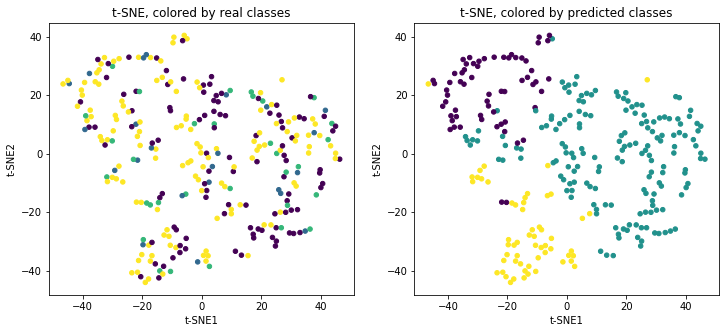

In [0]:
plt.rcParams['figure.figsize'] = (12, 5)

fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.scatter(x = tsne_data_10[:,0], y = tsne_data_10[:,1], c = df_test['phenotype'], s = 20)
ax1.set_xlabel('t-SNE1')
ax1.set_ylabel('t-SNE2')
ax1.set_title('t-SNE, colored by real classes')

ax2.scatter(x = tsne_data_10[:,0], y = tsne_data_10[:,1], c = df_test['predicted_cluster'], s = 20)
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.set_title('t-SNE, colored by predicted classes')

None


In [0]:
#tsne_data_25_pca = TSNE(n_components=2, perplexity = 25, verbose = 1).fit_transform(data_pca)

tsne_data_30_pca = TSNE(n_components=2, perplexity = 30, verbose = 1).fit_transform(data_pca)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.000s...
[t-SNE] Computed neighbors for 286 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 286 / 286
[t-SNE] Mean sigma: 2.802046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.505348
[t-SNE] KL divergence after 1000 iterations: 0.660215


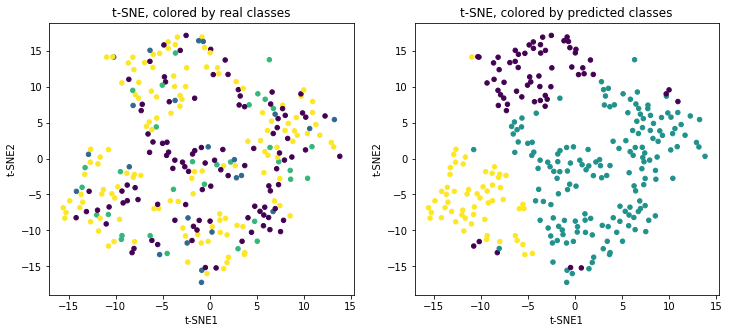

In [0]:
plt.rcParams['figure.figsize'] = (12, 5)

fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.scatter(x = tsne_data_30_pca[:,0], y = tsne_data_30_pca[:,1], c = df_test['phenotype'], s = 20)
ax1.set_xlabel('t-SNE1')
ax1.set_ylabel('t-SNE2')
ax1.set_title('t-SNE, colored by real classes')

ax2.scatter(x = tsne_data_30_pca[:,0], y = tsne_data_30_pca[:,1], c = df_test['predicted_cluster'], s = 20)
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.set_title('t-SNE, colored by predicted classes')

None